In [92]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy
import pandas as pd
import networkx as nx
import networkx.algorithms as algos
from functools import partial


from functions import *

# Initialize and Process Full Graph

In [93]:
#network from data
original=nx.Graph()

# add nodes
nodes = pd.read_csv("nodes_DE2023_methane.csv")
for i in range(0, nodes.shape[0]):
	# id,name,alias,type,x,y,height
	node = nodes.iloc[i]
	original.add_node(node.id, name=node.name, alias=node.alias, type=node.type, x=node.x, y=node.y, height=node.height)

# add edges
edges = pd.read_csv("edges_DE2023_methane.csv")
for i in range(0, edges.shape[0]):
	#id,node0_id,node1_id,name,alias,type,diameter,length,roughness,rin,rout,pimin,pomax
	edge = edges.iloc[i]
	original.add_edge(edge.node0_id, edge.node1_id, id=edge.id, name=edge.name, alias=edge.alias, type=edge.type, length=edge.length, roughness=edge.roughness, rin=edge.rin, rout=edge.rout, pimin=edge.pimin, pomax=edge.pomax)


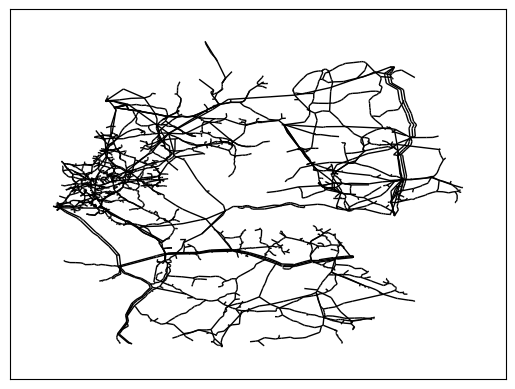

In [94]:
original_pos = {node: (data["x"], data["y"]) for node, data in original.nodes(data=True)}
nx.draw_networkx_edges(original, original_pos)

In [95]:
# translate every entry in nodes["alias"] to its property, save in nodes["type"]
nodes["type"] = nodes["alias"].copy().apply(lambda x: ''.join(re.findall(r'([A-Z]|[a-z])', str(x).split("_")[0]))).to_numpy()
# fill nan values in nodes["type"] with N
nodes["type"] = nodes["type"].apply(lambda x: "N" if str(x) == "nan" else x)

# Initialize NUTS Regions

In [96]:
nuts3 = gpd.read_file("./NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3]
nuts3.head(3)

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
NUTS_ID,,,,,,,,
AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."


<GeoAxes: >

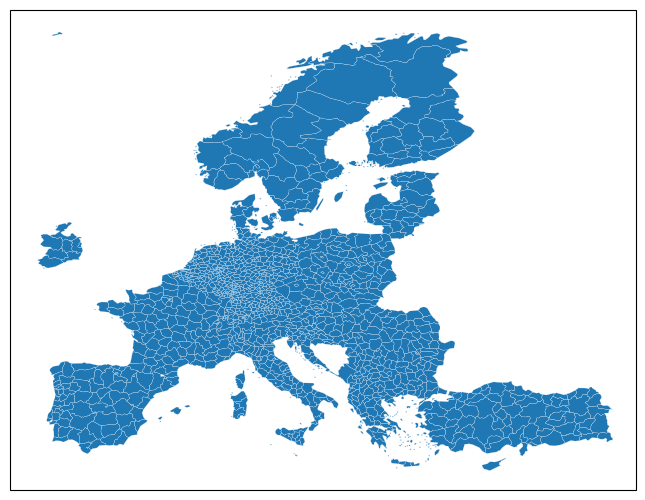

In [97]:
ax = plt.axes(
	[0, 0, 1, 1],
    projection=cartopy.crs.PlateCarree(),
	)

extent = [-13, 47, 33, 73]
ax.set_extent(extent, cartopy.crs.PlateCarree())

nuts3.plot(
	ax=ax,
	edgecolor='white',
	linewidth=0.15,

	)

# Run the Algorithms

In [98]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities

# Visualization and Investigation

In [99]:
greedy_modularity_results = run_algo(original, greedy_modularity_communities)

Gefundene Communities: 72
Modularität Q = 0.9614683589342857


In [100]:
greedy_modularity_graph, greedy_modularity_pos = build_results_graph(results=greedy_modularity_results, original_pos=original_pos)

###### Louvain is not deterministic here

In [101]:
louvain_results = run_algo(original, partial(louvain_communities, seed=42))

Gefundene Communities: 72
Modularität Q = 0.9614185745811639


In [102]:
louvain_communities_graph, louvain_communities_pos = build_results_graph(results=louvain_results, original_pos=original_pos)

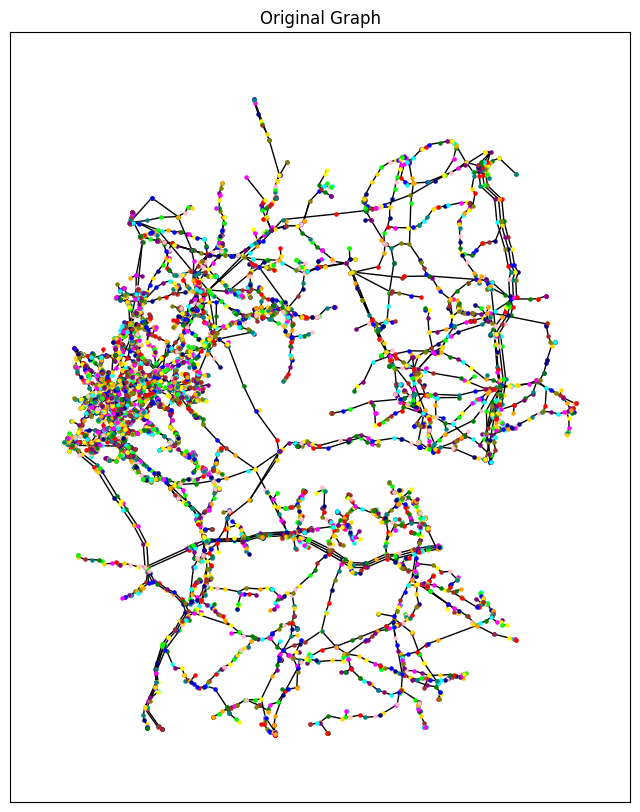

In [103]:
plot_network(graph=original, 
		pos=original_pos,
		node_size=5, 
		title="Original Graph"
)

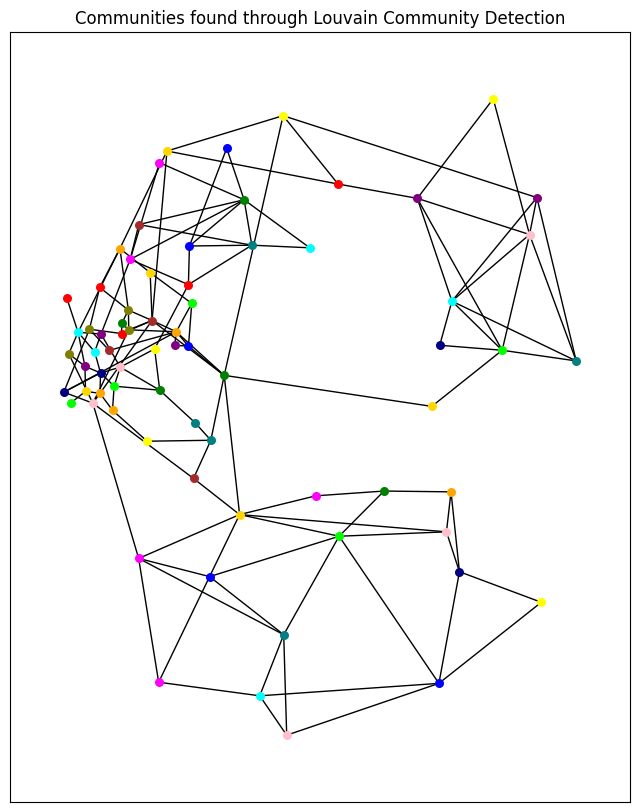

In [104]:
plot_network(graph=louvain_communities_graph, 
		pos=louvain_communities_pos,
		node_size=30, 
		title="Communities found through Louvain Community Detection"
)

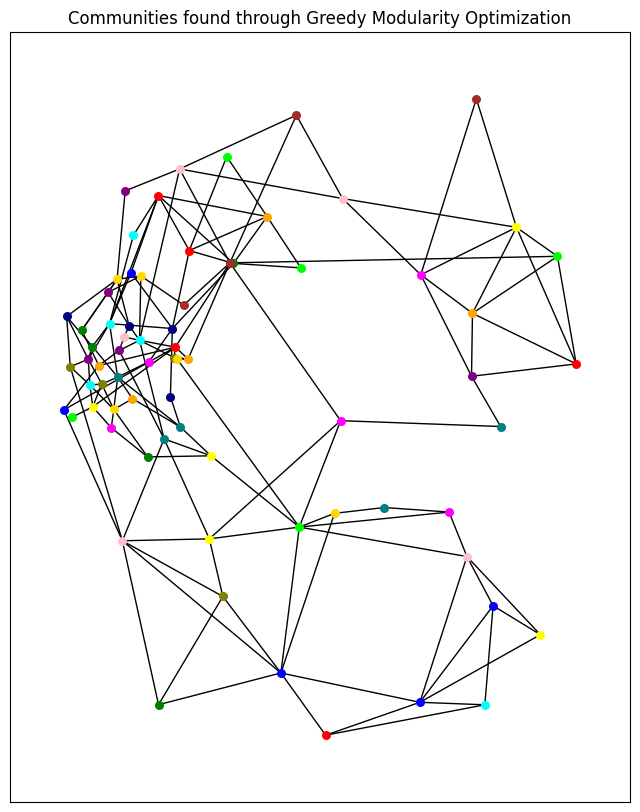

In [105]:
plot_network(graph=greedy_modularity_graph, 
		pos=greedy_modularity_pos, 
		node_size=30, 
		title="Communities found through Greedy Modularity Optimization"
)

In [106]:
minimum_spanning_tree = algos.tree.minimum_spanning_tree(original)

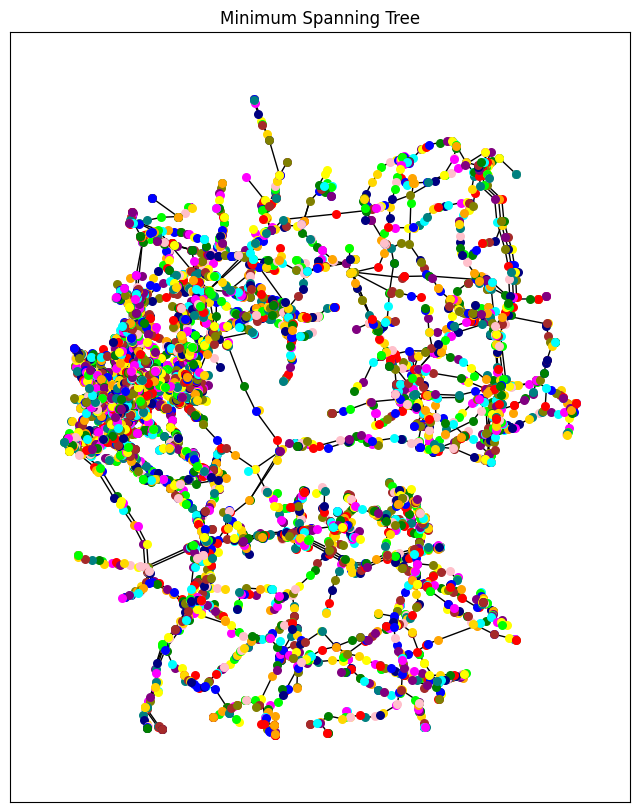

In [107]:
plot_network(graph=minimum_spanning_tree, 
		pos=original_pos, 
		node_size=30, 
		title="Minimum Spanning Tree"
)

In [108]:
nx.to_pandas_edgelist(original)

,source,target,id,rout,pomax,length,roughness,type,pimin,alias,name,rin
0,61801,61803,64879,NaN,NaN,5.308000,0.006,pipeline,NaN,NaN,5,NaN
1,61801,61853,64880,NaN,NaN,2.677000,0.006,pipeline,NaN,NaN,6,NaN
2,61802,61804,64881,NaN,NaN,9.826000,0.006,pipeline,NaN,NaN,7,NaN
3,61802,61853,64882,NaN,NaN,9.999000,0.006,pipeline,NaN,NaN,8,NaN
4,61803,61807,64883,NaN,NaN,9.999000,0.006,pipeline,NaN,NaN,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9192,69702,69703,74071,NaN,NaN,0.038000,0.006,pipeline,NaN,NaN,9192,NaN
9193,69720,69737,74072,NaN,NaN,0.004000,0.006,pipeline,NaN,NaN,9193,NaN
9194,69723,69737,74073,NaN,NaN,39.878872,0.006,pipeline,NaN,NaN,9194,NaN
9195,69737,69740,74074,NaN,NaN,46.944000,0.006,pipeline,NaN,NaN,9195,NaN
